In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
fraction = 50
reduction = 1/2
stride1 = 1
stride2 = 1
stride3 = 13
strides = stride1*stride2*stride3

datasetNo = 4

num_param = 10
num_time = 800
num_time_to = 780
num_node = int(14300/fraction)
#num_node = 14300
num_var = 1

n_epochs = 2000               # epoch to call
n_epochs_latent=200
batch_size = 1
LR = 1e-7
Lv1_latent_dim = int(128*8)
C1 = int(64*2/reduction)
C2 = int(128*2/reduction)
C3 = int(256*2/reduction)
print(Lv1_latent_dim)

alpha = 0

1024


In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[1,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 286, 8000)
8000


In [11]:
# validate
data.shape

(1, 286, 8000)

## FOM data type : FOM_data = np.array[param, time, node, var]

In [12]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data_temp = FOM_data
del FOM_data

FOM_data = np.zeros((num_param, num_time_to, num_node, num_var))
for i in range(num_time_to):
    FOM_data[:,i,:,:] = FOM_data_temp[:,i,:,:]

del FOM_data_temp
num_time_to = num_time
    
FOM_data.shape

#del data

(10, 780, 286, 1)

In [13]:
x_axis = np.linspace(0,num_node,num_node)

In [14]:
x_axis

array([  0.        ,   1.00350877,   2.00701754,   3.01052632,
         4.01403509,   5.01754386,   6.02105263,   7.0245614 ,
         8.02807018,   9.03157895,  10.03508772,  11.03859649,
        12.04210526,  13.04561404,  14.04912281,  15.05263158,
        16.05614035,  17.05964912,  18.06315789,  19.06666667,
        20.07017544,  21.07368421,  22.07719298,  23.08070175,
        24.08421053,  25.0877193 ,  26.09122807,  27.09473684,
        28.09824561,  29.10175439,  30.10526316,  31.10877193,
        32.1122807 ,  33.11578947,  34.11929825,  35.12280702,
        36.12631579,  37.12982456,  38.13333333,  39.13684211,
        40.14035088,  41.14385965,  42.14736842,  43.15087719,
        44.15438596,  45.15789474,  46.16140351,  47.16491228,
        48.16842105,  49.17192982,  50.1754386 ,  51.17894737,
        52.18245614,  53.18596491,  54.18947368,  55.19298246,
        56.19649123,  57.2       ,  58.20350877,  59.20701754,
        60.21052632,  61.21403509,  62.21754386,  63.22

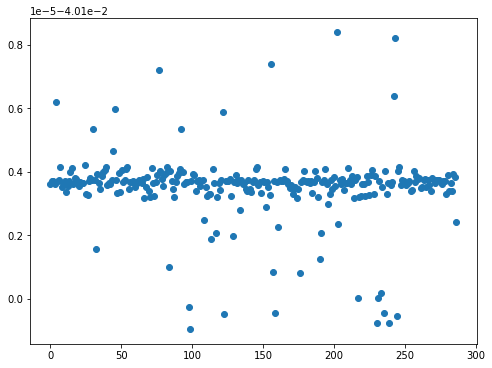

In [15]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [16]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0400963761125
-0.0489409761125
-0.0413117761125
-0.040096287525


In [17]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [18]:
print(maximum)
print(minimum)
print(mean)
print(AT)

0.143542529125
-0.1364653525
0.0006077139113373788
0.280007881625


In [19]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
FOM_data = FOM_data-np.min(FOM_data)

In [20]:
print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [21]:
FOM_data.shape

(10, 780, 286, 1)

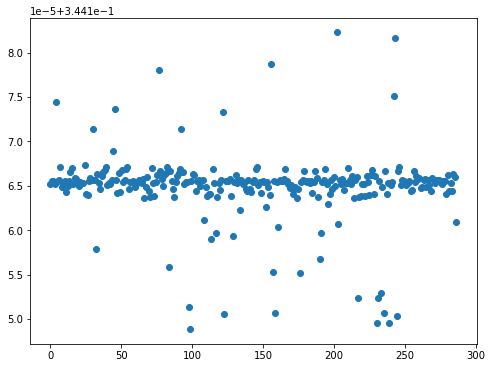

In [22]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [23]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(7800, 286, 1)

In [24]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [25]:
Lv1_input_shape = Lv1_input.shape[1:]

In [26]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(7800, 286, 1)
(286, 1)


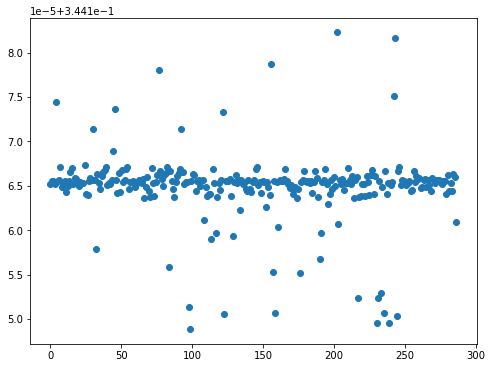

In [27]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Acquire latent vectors

In [28]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

#del Encoder
#del Decoder

epoch = n_epochs
filename1='test_constrained/encoder_COPY_%d.h5' % (epoch)
filename2='test_constrained/decoder_COPY_%d.h5' % (epoch)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 780, 286, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 22, 1024) 26624       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 22, 1024) 4096        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 60, 22, 1024) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [29]:
n_epochs_latent

200

In [30]:
Lv1_input = FOM_data

In [31]:
FOM_data.shape

(10, 780, 286, 1)

In [32]:
latent_vector_save=np.zeros([num_param, Lv1_latent_dim])

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    
    mu, var,latent_temp = Encoder(x_train, training=False)
    latent_vector = reparam(mu[-1], var[-1])
    latent_vector = np.reshape(latent_vector, [-1, Lv1_latent_dim])
    gen_x, _ = Decoder(latent_vector, training=False)
    
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, Lv1_latent_dim])

latent_vector = np.zeros([1, Lv1_latent_dim])
loss_save = np.ones([num_param])*1000

for i in range(n_epochs_latent): 
    for j in range(num_param):
        x = FOM_data[j, :,:,:]
        x = np.reshape(x,(1,x.shape[0],x.shape[1],x.shape[2]))
        
        latent_vector, gen_x = find_latent(x)
        
        loss = tf.math.reduce_mean(tf.math.square(x - gen_x))
        
        if loss < loss_save[j]:
            loss_save[j] = loss
            latent_vector_save[j] = latent_vector
            
    del latent_vector
    print('Epoch: {}'.format(i))
    print(loss_save)
        
latent_vectors = latent_vector_save
del latent_vector_save
    
end_param=time.time()

Epoch: 0
[0.35498568 0.36063394 0.36824051 0.37808344 0.38804486 0.40090853
 0.41453823 0.42992881 0.44609684 0.46378344]
Epoch: 1
[0.35444662 0.36063394 0.36791167 0.37701127 0.38804486 0.40039837
 0.41432208 0.42992881 0.44609684 0.46367502]
Epoch: 2
[0.35444662 0.36063394 0.36791167 0.37701127 0.38804486 0.39987424
 0.41432208 0.42864612 0.44603232 0.46286237]
Epoch: 3
[0.35444662 0.36025402 0.36791167 0.37701127 0.38804486 0.39987424
 0.41432208 0.42864612 0.44506329 0.46286237]
Epoch: 4
[0.35444662 0.36025402 0.36791167 0.37687272 0.38804486 0.39987424
 0.41432208 0.42864612 0.44506329 0.46286237]
Epoch: 5
[0.35444662 0.36025402 0.36759141 0.37687272 0.38804486 0.39987424
 0.41432208 0.42864612 0.44506329 0.46286237]
Epoch: 6
[0.35444662 0.36025402 0.36759141 0.37687272 0.38804486 0.39987424
 0.41432208 0.42864612 0.44506329 0.46286237]
Epoch: 7
[0.35444662 0.36025402 0.36759141 0.37687272 0.38804486 0.39987424
 0.41432208 0.42864612 0.44506329 0.46286237]
Epoch: 8
[0.35444662 0.3

Epoch: 67
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 68
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 69
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 70
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 71
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 72
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 73
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 74
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.39948946
 0.41288769 0.42833519 0.44506329 0.46280167]
Epoch: 75
[0.353

Epoch: 134
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 135
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 136
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 137
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 138
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 139
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 140
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 141
[0.35333791 0.35944739 0.36759141 0.37657741 0.38738388 0.3993727
 0.41288769 0.42830738 0.4447667  0.46280167]
Epoch: 142
[0.35

In [33]:
loss_save

array([0.35212395, 0.35944739, 0.36757866, 0.37620509, 0.38738388,
       0.3993727 , 0.41288769, 0.42817339, 0.4447667 , 0.46278408])

In [34]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

In [35]:
for_decoder = np.reshape(latent_vectors, [-1, Lv1_latent_dim])

In [36]:
for_decoder1 = np.zeros([Lv1_latent_dim])
for_decoder1[:] = for_decoder[0,:]
for_decoder2 = np.reshape(for_decoder1, [-1, Lv1_latent_dim])

In [37]:
EX,_ = Decoder(for_decoder2)

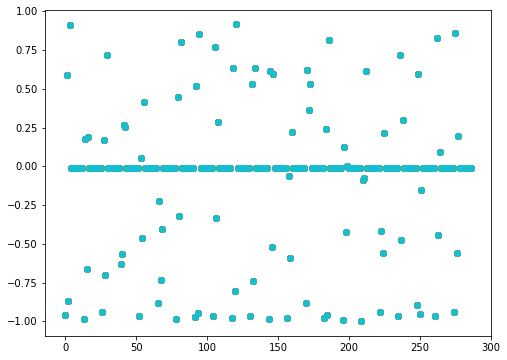

In [38]:
for i in range(100):
    plt.scatter(x_axis, EX[0,2,:,0])
    

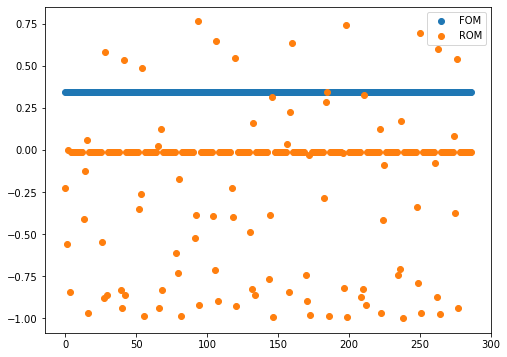

In [39]:

plt.scatter(x_axis, Lv1_input[0,0,:,0], label = 'FOM')
plt.scatter(x_axis, EX[0,0,:,0], label = 'ROM')
plt.legend()

# Output latent vectors to file,

In [40]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

NameError: name 'Lv1_latent' is not defined

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [ ]:
pause;